In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model 
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from PIL import Image
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline

## CÀRREGA DE DADES

In [2]:
train_path = "Mushrooms_V50_T50/train"
valid_path = "Mushrooms_V50_T50/valid"
test_path = "Mushrooms_V50_T50/test"

In [3]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
directory=train_path,target_size=(224,224),batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
directory=valid_path,target_size=(224,224),batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
directory=test_path,target_size=(224,224),batch_size=32,shuffle=False)

Found 8072 images belonging to 12 classes.
Found 600 images belonging to 12 classes.
Found 600 images belonging to 12 classes.


### CÀRREGA MODEL MOBILENET

In [4]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [5]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

#### FINETUNNING

In [6]:
x = mobile.layers[-6].output
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)
output = Dense(units=12,activation="softmax")(x)

In [7]:
model = Model(inputs=mobile.input,outputs=output)

In [8]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

### ENTRENAMENT DEL MODEL

In [10]:
model.compile(optimizer=Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
modelcheckpoint = ModelCheckpoint("model_mobile.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1) 


history = model.fit(
    train_batches,
    steps_per_epoch = train_batches.samples / 32, 
    epochs = 100,
    validation_data = valid_batches,
    validation_steps = valid_batches.samples / 32,
    callbacks = [modelcheckpoint, earlystopping])

Epoch 1/100
252/252 [==============================] - 467s 2s/step - loss: 2.5083 - accuracy: 0.3285 - val_loss: 1.4433 - val_accuracy: 0.5733

Epoch 00001: val_accuracy improved from -inf to 0.57333, saving model to model_mobile.h5
Epoch 2/100
252/252 [==============================] - 456s 2s/step - loss: 1.0512 - accuracy: 0.6737 - val_loss: 0.9433 - val_accuracy: 0.6883

Epoch 00002: val_accuracy improved from 0.57333 to 0.68833, saving model to model_mobile.h5
Epoch 3/100
252/252 [==============================] - 458s 2s/step - loss: 0.6772 - accuracy: 0.7726 - val_loss: 0.8268 - val_accuracy: 0.7217

Epoch 00003: val_accuracy improved from 0.68833 to 0.72167, saving model to model_mobile.h5
Epoch 4/100
252/252 [==============================] - 452s 2s/step - loss: 0.4947 - accuracy: 0.8359 - val_loss: 0.8180 - val_accuracy: 0.7350

Epoch 00004: val_accuracy improved from 0.72167 to 0.73500, saving model to model_mobile.h5
Epoch 5/100
252/252 [==============================] - 

252/252 [==============================] - 508s 2s/step - loss: 0.0066 - accuracy: 0.9984 - val_loss: 1.1669 - val_accuracy: 0.7783

Epoch 00040: val_accuracy did not improve from 0.80167
Epoch 41/100
252/252 [==============================] - 517s 2s/step - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.9295 - val_accuracy: 0.7850

Epoch 00041: val_accuracy did not improve from 0.80167
Epoch 42/100
252/252 [==============================] - 506s 2s/step - loss: 0.0102 - accuracy: 0.9966 - val_loss: 1.2399 - val_accuracy: 0.7833

Epoch 00042: val_accuracy did not improve from 0.80167
Epoch 43/100
252/252 [==============================] - 504s 2s/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 1.6435 - val_accuracy: 0.7233

Epoch 00043: val_accuracy did not improve from 0.80167
Epoch 44/100
252/252 [==============================] - 506s 2s/step - loss: 0.0110 - accuracy: 0.9974 - val_loss: 1.1135 - val_accuracy: 0.7833

Epoch 00044: val_accuracy did not improve from 0.80167
Epoch 45

### Carreguem el model guardat

In [13]:
model_mobile=tf.keras.models.load_model('model_mobile.h5')

Altres models creats:

# Model Evaluate

In [14]:
test_loss, test_acc = model_mobile.evaluate(test_batches,verbose=1)

19/19 [==============================] - 20s 1s/step - loss: 0.7950 - accuracy: 0.7983


# Model predictions / Confusion Matrix

In [15]:
test_labels = test_batches.classes

In [16]:
predictions = model_mobile.predict(x=test_batches,verbose=0)

In [17]:
cm = confusion_matrix(y_true=test_labels,y_pred=predictions.argmax(axis=1))

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


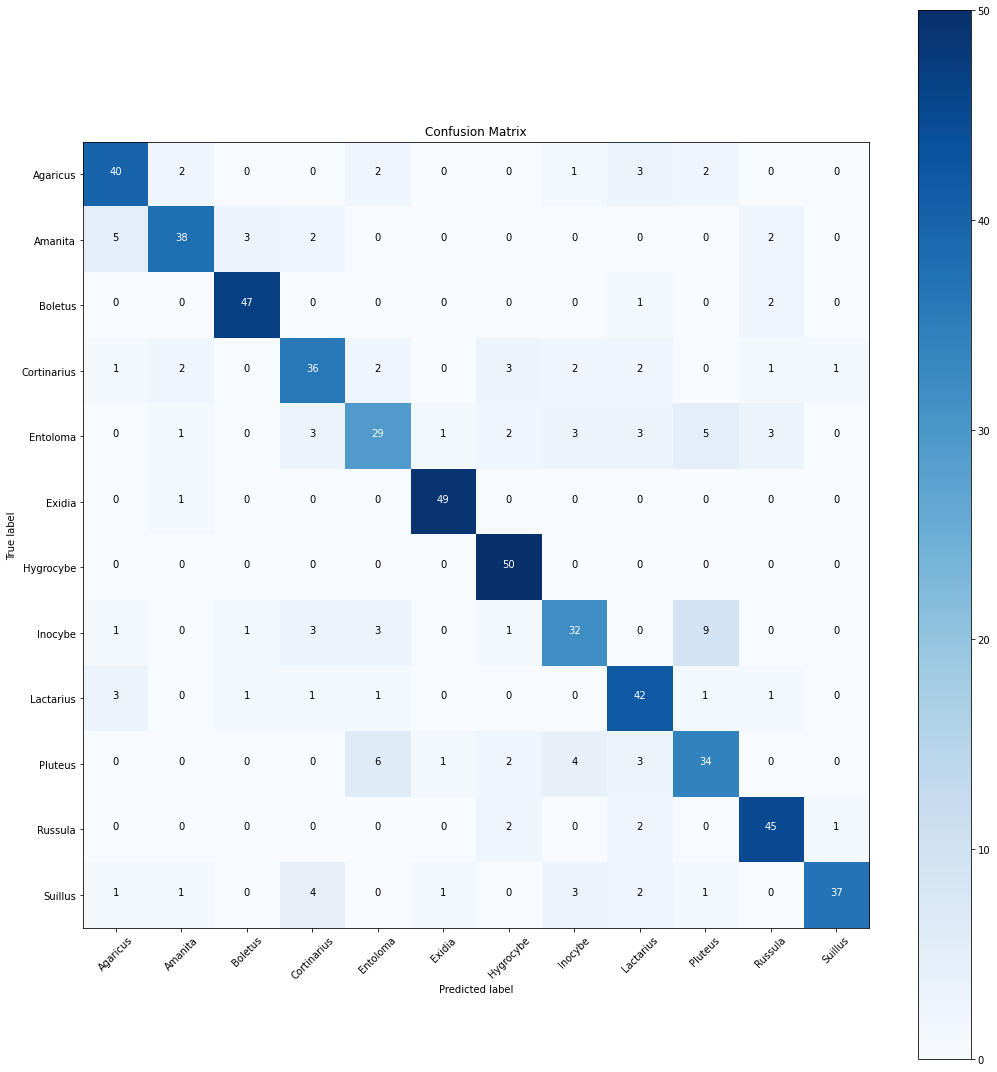

In [19]:
cm_plot_labels=['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Exidia', 'Hygrocybe', 'Inocybe', 'Lactarius', 'Pluteus', 'Russula', 'Suillus']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title="Confusion Matrix")

# EXEMPLE IMAGE CLASSIFICATION

In [20]:
def prepare_image(file):
    img_path = "Mushrooms/"
    img = image.load_img(img_path + file, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array,axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

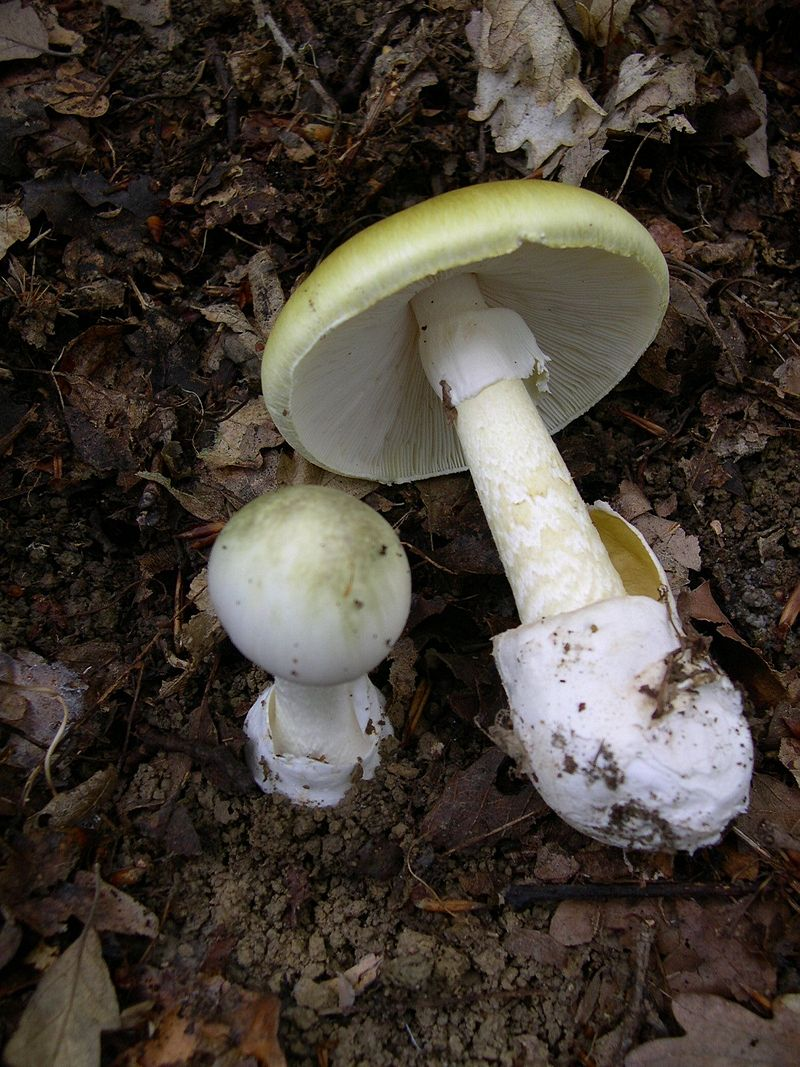

In [21]:
from IPython.display import Image 
Image(filename="Mushrooms/amanita_phalloides_test.jpg",width=300,height=200)

In [22]:
preprocessed_image=prepare_image("amanita_phalloides_test.jpg")
predictions = model_mobile.predict(preprocessed_image)

numbers_sort = sorted(enumerate(predictions[0]), key=lambda x: x[1],  reverse=True)
for i in range(3):
    print("Prob: {1} -- ".format(*numbers_sort[i]),"specie: {0}".format(*list(test_batches.class_indices.items())[numbers_sort[i][0]]))


Prob: 0.999729573726654 --  specie: Amanita
Prob: 0.00020218986901454628 --  specie: Cortinarius
Prob: 3.409052806091495e-05 --  specie: Agaricus


# APP ANDROID

Convertir a model .tflite

In [23]:
converter=tf.lite.TFLiteConverter.from_keras_model(model_mobile)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\polco\AppData\Local\Temp\tmp_d4g6dk_\assets


In [24]:
open("best_model_mobile.tflite", "wb").write(tflite_model)

12857940

Guardem .txt amb els labels

In [25]:
labels = '\n'.join(sorted(train_batches.class_indices.keys()))
with open('labels.txt', 'w') as f:
    f.write(labels)